# Object Detection Fine Tuning

For this tutorial, we will be finetuning a pre-trained Mask R-CNN model on the Penn-Fudan Database for Pedestrian Detection and Segmentation.

# Penn-Fudan Database
- This is an image database containing images that are used for pedestrian detection. The images are taken from scenes around campus and urban street.

- Annotated with Pascal annotation (https://towardsai.net/p/machine-learning/understanding-pascal-voc-and-coco-annotations-for-object-detection)

-  It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an object detection and instance segmentation model on a custom dataset.

![image.png](https://i.ibb.co/pZvptMy/workshop4-1-penn-fudan-dataset.png)
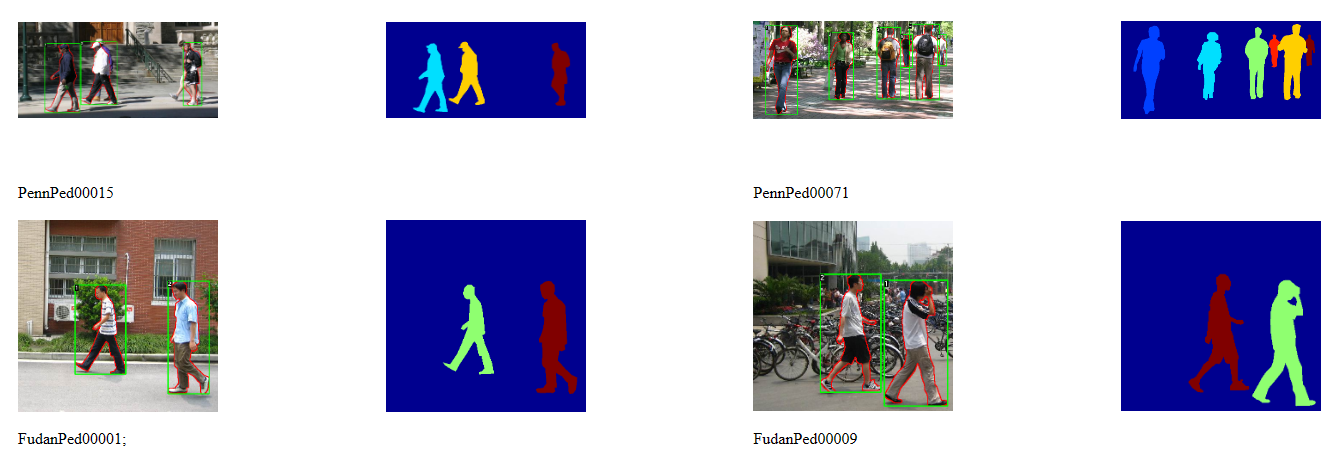

# References
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# Libraries

In [1]:
%%capture
!pip install torchinfo
!mkdir vlm_app

In [2]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


helper

In [3]:
import os
import urllib


def download_file(url, path=None):
    """helper function to download a file from a URL"""
    if path is None:
        path = url.split("/")[-1]

    if os.path.exists(path):
        print(f"File '{path}' already exists.")
        return

    try:
        urllib.URLopener().retrieve(url, path)
    except:
        urllib.request.urlretrieve(url, path)

    print(f"File '{path}' downloaded successfully.")

# Data
- Download and extract the data file (zip files)

%%capture is used to supress the output of the extraction process.

In [4]:
%%capture
!mkdir data
download_file("https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip", "data/PennFudanPed.zip")
!cd data && unzip -o PennFudanPed.zip

note the file sturcture of the downloaded zip

In [5]:
# PennFudanPed/
#   PedMasks/
#     FudanPed00001_mask.png
#     FudanPed00002_mask.png
#     FudanPed00003_mask.png
#     FudanPed00004_mask.png
#     ...
#   PNGImages/
#     FudanPed00001.png
#     FudanPed00002.png
#     FudanPed00003.png
#     FudanPed00004.png

## Example Data
To plot an example pair of images and segmentation masks.

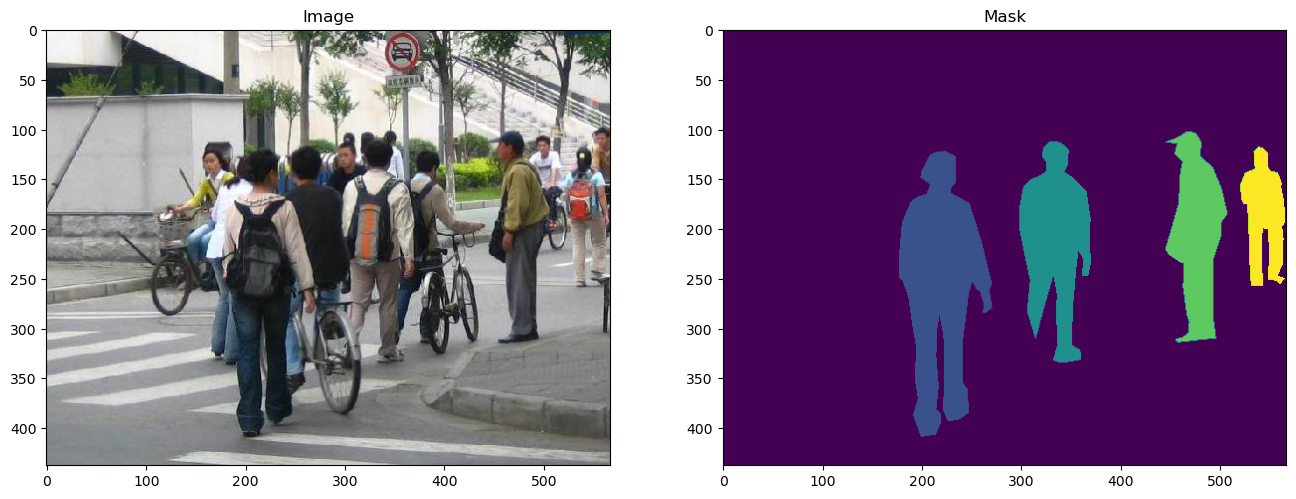

In [6]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

So each image has a corresponding segmentation mask, where each color correspond to a different instance. 


## Custom Dataset
To work with our dataset, we need to create a custom dataset class that inherits from `torch.utils.data.Dataset`. This class requires us to define the `__getitem__` function, which retrieves a specific data point from the dataset. (https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

In our implementation, we wrap images, bounding boxes, and masks as tensors using `torchvision.tv_tensors`. Specifically:

- Images are wrapped as torchvision.tv_tensors.Image tensors

- Bounding boxes are wrapped as torchvision.tv_tensors.BoundingBoxes tensors

- Masks are wrapped as torchvision.tv_tensors.Mask tensors

These wrapped tensors are subclasses of torch.Tensor, allowing us to perform consistent transformations using torchvision.transforms.v2 later on. This ensures a seamless integration with PyTorch's tensor API.

In [7]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(
            boxes, format="XYXY", canvas_size=F.get_size(img)
        )
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Background
In this tutorial, we will be using Mask R-CNN, which is based on top of Faster R-CNN. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![image.png](https://i.ibb.co/NnstT2j/workshop-4-1-rcnn.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![image-2.png](https://i.ibb.co/tpWbm3T/workshop4-1-maskrcnn.png)

There are two common situations where one might want to modify one of the available models in TorchVision Model Zoo. The first is when we want to start from a pre-trained model, and just finetune the last layer (Example 1). The other is when we want to replace the backbone of the model with a different one (such as for faster predictions) (Example 2).

Let’s go see how we would do one or another in the following sections.
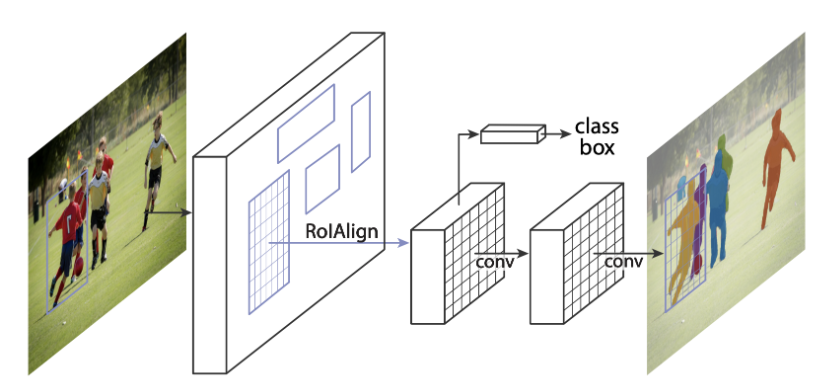
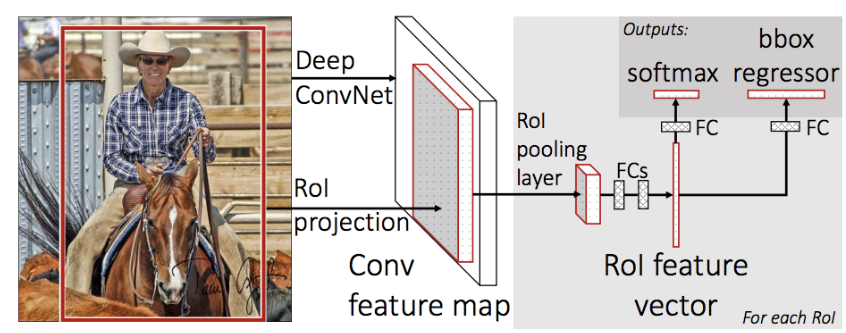

In [8]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

# Object Detection + Instance Segmentation (Mask-CNN)

We are setting up a Mask-CNN model for object detection and instance segmentation. Specifically, we want to fine-tune a pre-trained Mask-RCNN model, which is an extension of Faster-RCNN with an additional layer that computes instance segmentation masks

## Modifying Heads
To adapt the pre-trained model to our specific task, we need to modify the classifier heads. In this case, we need to update the num_classes parameter at two layers:

- The classification head (e.g., cls_head)

- The mask head (e.g., mask_head)

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

printing layer summary

In [10]:
from torchinfo import summary

model = get_model_instance_segmentation(2)
summary(
    model,
    input_size=(32, 3, 112, 112),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
MaskRCNN                                                [32, 3, 112, 112]         [100, 4]                  --                        Partial
├─GeneralizedRCNNTransform: 1-1                         [32, 3, 112, 112]         [32, 3, 800, 800]         --                        --
├─BackboneWithFPN: 1-2                                  [32, 3, 800, 800]         [32, 256, 13, 13]         --                        Partial
│    └─IntermediateLayerGetter: 2-1                     [32, 3, 800, 800]         [32, 2048, 25, 25]        --                        Partial
│    │    └─Conv2d: 3-1                                 [32, 3, 800, 800]         [32, 64, 400, 400]        (9,408)                   False
│    │    └─FrozenBatchNorm2d: 3-2                      [32, 64, 400, 400]        [32, 64, 400, 400]        --                        --
│    │    └─ReLU

That’s it, this will make model be ready to be trained and evaluated on your custom dataset.

# Putting everything together
To simplify training and evaluating detection models, we will use helper functions from the references/detection/ directory. Specifically, we will use the following files:
- engine.py
- utils.py

which will also need the others (coco_utils) etc to function properly.

In [17]:
download_file(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py"
)
download_file(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py"
)
download_file(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py"
)
download_file(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py"
)
download_file(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"
)

File 'engine.py' already exists.
File 'utils.py' already exists.
File 'coco_utils.py' already exists.
File 'coco_eval.py' already exists.
File 'transforms.py' already exists.


Let’s write some helper functions for data augmentation / transformation for data augmentation pipelines for Object Detection and Segmentation tasks:

In [12]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

# Setup

Given that our dataset is very small, we will be training with only 2 epoch.

Let’s now write the main function which performs the training and the validation:


In [13]:
import utils
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset("data/PennFudanPed", get_transform(train=True))
dataset_test = PennFudanDataset("data/PennFudanPed", get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn,
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Model Training

In [14]:
# let's train it just for 1 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("Completed!")

Epoch: [0]  [ 0/60]  eta: 0:01:02  lr: 0.000090  loss: 4.9267 (4.9267)  loss_classifier: 1.1338 (1.1338)  loss_box_reg: 0.1835 (0.1835)  loss_mask: 3.5673 (3.5673)  loss_objectness: 0.0406 (0.0406)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 1.0470  data: 0.2101  max mem: 8182
Epoch: [0]  [10/60]  eta: 0:00:29  lr: 0.000936  loss: 1.6373 (2.6086)  loss_classifier: 0.5460 (0.5939)  loss_box_reg: 0.1976 (0.2459)  loss_mask: 1.0047 (1.7382)  loss_objectness: 0.0141 (0.0254)  loss_rpn_box_reg: 0.0054 (0.0052)  time: 0.5968  data: 0.0251  max mem: 8182
Epoch: [0]  [20/60]  eta: 0:00:23  lr: 0.001783  loss: 0.9910 (1.7502)  loss_classifier: 0.2537 (0.4241)  loss_box_reg: 0.2135 (0.2563)  loss_mask: 0.3690 (1.0409)  loss_objectness: 0.0141 (0.0218)  loss_rpn_box_reg: 0.0064 (0.0070)  time: 0.5553  data: 0.0068  max mem: 8182
Epoch: [0]  [30/60]  eta: 0:00:16  lr: 0.002629  loss: 0.6281 (1.3634)  loss_classifier: 0.1356 (0.3188)  loss_box_reg: 0.2122 (0.2435)  loss_mask: 0.2404 (0.7760)  loss_ob

So after one epoch of training, we obtain a COCO-style mAP > 50, and a mask mAP of 65.

# Results

But what do the predictions look like? Let’s take one image in the dataset and verify

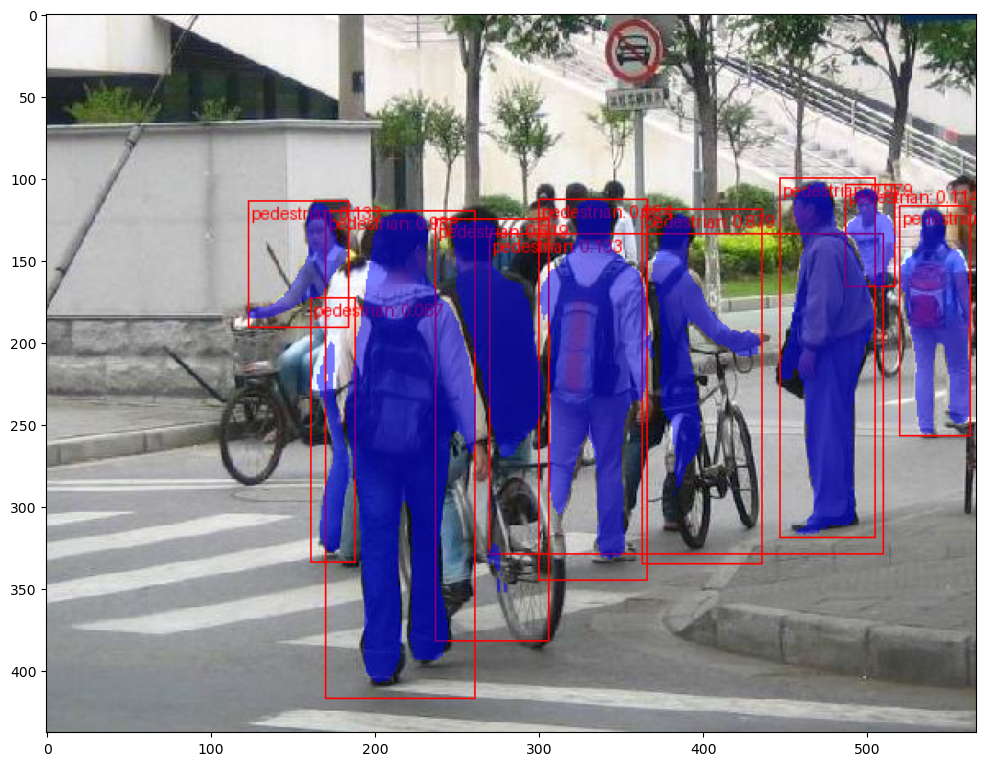

In [15]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # torch_vision read images as RGBA
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model(
        [
            x,
        ]
    )
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [
    f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])
]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

The results look good!

# Saving the Model for FastAPI

In [16]:
torch.save(model, "vlm_app/fine_tuned_OD_pedestrian_model.pth")

# Wrapping up
In this tutorial, you have learned how to create your own training pipeline for object detection models on a custom dataset. 

For that, 
- you wrote a torch.utils.data.Dataset class that returns the images and the ground truth boxes and segmentation masks
- You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-GPU training, check references/detection/train.py, which is present in the torchvision repository.

# Exercise (15 minutes)
**1. Can you modified the code to run OD via one-stage detection instead (such as `ssdlite320_mobilenet_v3_large`)?**

You could start with 
```
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(num_classes=2, weights_backbone='DEFAULT', trainable_backbone_layers=0)

summary(model,
        verbose=0,
        input_size=(32, 3, 320, 320),
        col_names=["input_size", "output_size", "num_params", "trainable"],)
```